# Notebook 2: Train on the Pre-Generated Augmented Dataset

This notebook represents the final stage of our experimentation.

1.  **Dataset:** We will use the large, static dataset we created in the `generate_augmented_dataset.ipynb` notebook. This dataset includes our most advanced augmentation techniques, including **chunk shuffling**.
2.  **Feature Extraction:** We will use the feature representation that has proven to be the most effective: **Mel spectrograms**.
3.  **Model:** We will use our best-performing model architecture: the binary CNN with `EarlyStopping`.

The goal is to see if training our best model on our best, most diverse dataset can achieve a new level of performance. Because the data is already generated, this notebook will be much simpler and faster to execute for repeated training runs.


## 1. Setup and Imports


In [54]:
%pip install tensorflow scikit-learn librosa numpy pandas matplotlib seaborn tqdm


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\fe_de\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [55]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

sns.set_theme(style="whitegrid")


## 2. Load Data and Convert to Spectrograms

This process is now much simpler. We don't need any augmentation functions. We just need to:
1.  Get a list of all file paths from our new `Audios-Augmented` directory.
2.  Split these file paths into training and validation sets.
3.  Process each set by loading the audio and converting it to a Mel spectrogram.


In [56]:
# --- Parameters ---
AUGMENTED_DATASET_DIR = 'Audios-Augmented/'
ORIGINAL_DATASET_DIR = 'Audios para Treinamento/'
FIXED_DURATION_S = 10
SAMPLE_RATE = 22050
FIXED_LENGTH = SAMPLE_RATE * FIXED_DURATION_S

# --- Group-based splitting to prevent data leakage ---
# 1. Get original files to define the groups
original_files_meta = []
for label_group, subdirs in [('Leak', ['Leak-Metal', 'Leak-NonMetal']), ('NoLeak', ['NoLeak-Metal', 'NoLeak-NonMetal'])]:
    for subdir in subdirs:
        class_path = os.path.join(ORIGINAL_DATASET_DIR, subdir)
        if os.path.isdir(class_path):
            files = [f for f in os.listdir(class_path) if f.endswith('.wav')]
            for f in files:
                original_files_meta.append({'stem': os.path.splitext(f)[0], 'label': label_group})

original_df = pd.DataFrame(original_files_meta)
print(f"Found {len(original_df)} original audio files to define groups.")

# 2. Split the ORIGINAL files into training and validation groups (stratified)
train_stems, val_stems, _, _ = train_test_split(
    original_df['stem'],
    original_df['label'],
    test_size=0.2,
    random_state=42,
    stratify=original_df['label']
)
train_stems = set(train_stems)
val_stems = set(val_stems)
print(f"Split into {len(train_stems)} original files for training and {len(val_stems)} for validation.")

# 3. Assign each augmented file to its corresponding train or validation set
train_files, train_labels = [], []
val_files, val_labels = [], []

for label in ['Leak', 'NoLeak']:
    class_path = os.path.join(AUGMENTED_DATASET_DIR, label)
    if os.path.isdir(class_path):
        augmented_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.wav')]
        for aug_file_path in augmented_files:
            augmented_stem = os.path.splitext(os.path.basename(aug_file_path))[0]
            
            # Find which original stem this augmented file came from
            original_stem = None
            for s in original_df.stem:
                if augmented_stem.startswith(s):
                    original_stem = s
                    break
            
            if original_stem in train_stems:
                train_files.append(aug_file_path)
                train_labels.append(label)
            elif original_stem in val_stems:
                val_files.append(aug_file_path)
                val_labels.append(label)

print(f"\nTotal files in augmented dataset: {len(train_files) + len(val_files)}")
print(f"Training files (augmented): {len(train_files)}")
print(f"Validation files (augmented): {len(val_files)}")

# Check if the split was successful
if len(train_files) == 0 or len(val_files) == 0:
    print("\nWARNING: One of the data splits is empty. Please check the file naming convention and paths.")
    print("This can happen if the augmented filenames do not start with the original filenames.")

# --- Function to process audio to Mel Spectrogram ---
def audio_to_melspectrogram(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        if len(audio) < FIXED_LENGTH:
            audio = np.pad(audio, (0, FIXED_LENGTH - len(audio)), 'constant')
        else:
            audio = audio[:FIXED_LENGTH]
        
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128)
        return librosa.power_to_db(spectrogram, ref=np.max)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


Found 60 original audio files to define groups.
Split into 48 original files for training and 12 for validation.

Total files in augmented dataset: 300
Training files (augmented): 240
Validation files (augmented): 60


In [57]:
# This cell was intentionally left blank. The model saving logic has been moved to after the training and evaluation steps.


In [58]:
print("Processing training data...")
X_train = np.array([audio_to_melspectrogram(file) for file in tqdm(train_files)])
y_train = np.array(train_labels)

print("\nProcessing validation data...")
X_val = np.array([audio_to_melspectrogram(file) for file in tqdm(val_files)])
y_val = np.array(val_labels)

# --- Prepare data for the model ---
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


Processing training data...


100%|██████████| 240/240 [00:01<00:00, 161.58it/s]



Processing validation data...


100%|██████████| 60/60 [00:00<00:00, 166.14it/s]


Training set shape: (240, 128, 431, 1)
Validation set shape: (60, 128, 431, 1)


## 3. Build, Train, and Evaluate the Model

We will use the same successful binary CNN architecture from our previous experiments. We'll train it on our new, large dataset and use `EarlyStopping` to ensure we capture the best possible version of the model.


In [59]:
# --- Define the EarlyStopping callback ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

EPOCHS = 75
BATCH_SIZE = 32

history = model.fit(X_train, y_train_enc,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val_enc),
                    verbose=1,
                    callbacks=[early_stopping])


C:\Users\fe_de\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 429, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 214, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 212, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 106, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 104, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,313 (427.00 KB)

 Trainable params: 109,313 (427.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.5042 - loss: 2.0896 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.4458 - loss: 1.0441 - val_accuracy: 0.5000 - val_loss: 0.6897
Epoch 3/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.5375 - loss: 0.7419 - val_accuracy: 0.5000 - val_loss: 0.6878
Epoch 4/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.5042 - loss: 0.7300 - val_accuracy: 0.5000 - val_loss: 0.6864
Epoch 5/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6208 - loss: 0.6684 - val_accuracy: 0.5000 - val_loss: 0.6803
Epoch 6/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.4750 - loss: 0.7003 - val_accuracy: 0.5000 - val_loss: 0.6842
Epoch 7/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.5542 - loss: 0.6809 - val_accuracy: 0.5000 - val_loss: 0.6819
Epoch 8/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.5583 - loss: 0.6876 - val_accuracy: 0.5500 - val_loss:

## 4. Final Evaluation


## 4.5 Save Model and Encoder

After training and evaluating, we save the model and the label encoder to disk. This allows us to load them later for inference or conversion without needing to retrain.


In [60]:
import joblib

# --- Define file paths ---
model_save_path = "water_leak_model.h5"
label_encoder_path = "label_encoder.joblib"

# --- Save the trained model ---
# We use .h5 format for broader compatibility, especially with older TensorFlow versions.
model.save(model_save_path)
print(f"Model saved successfully to: {model_save_path}")

# --- Save the label encoder ---
joblib.dump(label_encoder, label_encoder_path)
print(f"Label encoder saved successfully to: {label_encoder_path}")


Model saved successfully to: water_leak_model.h5
Label encoder saved successfully to: label_encoder.joblib


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
--- VALIDATION SET PERFORMANCE ---
Classification Report:
              precision    recall  f1-score   support

        Leak       0.62      0.87      0.72        30
      NoLeak       0.78      0.47      0.58        30

    accuracy                           0.67        60
   macro avg       0.70      0.67      0.65        60
weighted avg       0.70      0.67      0.65        60



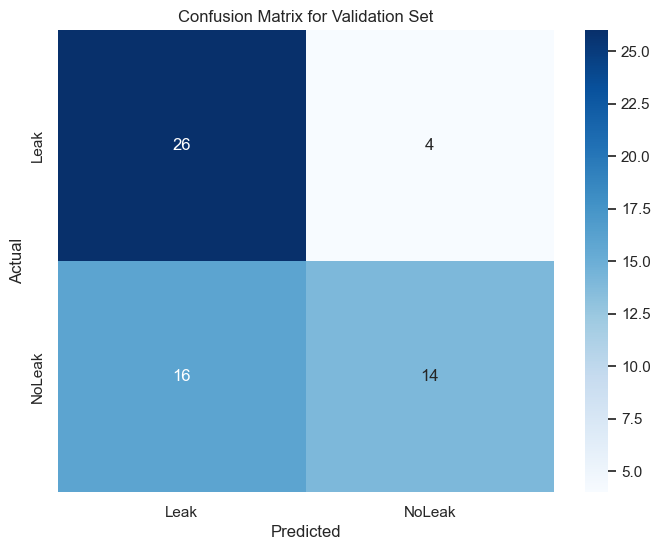

In [67]:
# --- Make predictions on the validation set ---
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype("int32")

# --- Print classification report ---
print("--- VALIDATION SET PERFORMANCE ---")
print("Classification Report:")
print(classification_report(y_val_enc, y_pred, target_names=label_encoder.classes_))

# --- Plot confusion matrix ---
conf_matrix = confusion_matrix(y_val_enc, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Validation Set')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 5. Predict on New Audio Files

Now that we have a trained and evaluated model, let's use it to make predictions on the new audio files you provided in the `Our own/` directory.

This process will involve:
1.  Loading each new `.mp3` file.
2.  Processing it into the same Mel spectrogram format the model was trained on.
3.  Using the `model.predict()` method.
4.  Displaying the predicted label ("Leak" or "NoLeak") for each file.

**Note:** `librosa` requires `ffmpeg` to be installed on your system to load `.mp3` files. If you encounter errors in the next cell, please ensure `ffmpeg` is installed and accessible in your system's PATH.


In [68]:
import glob

# --- Directory containing your new audio files ---
NEW_AUDIO_DIR = 'Our own/'
# Note: Librosa can handle various audio formats, including .mp3 and .wav
print(f"Searching for audio files in: {os.path.abspath(NEW_AUDIO_DIR)}")
new_audio_files_mp3 = glob.glob(os.path.join(NEW_AUDIO_DIR, '*.mp3'))
new_audio_files_wav = glob.glob(os.path.join(NEW_AUDIO_DIR, '*.wav'))
new_audio_files = new_audio_files_mp3 + new_audio_files_wav

if not new_audio_files:
    print(f"Could not find any .mp3 or .wav files in the directory.")
else:
    print(f"Found {len(new_audio_files)} files to predict on.")
    
    # --- Process audio files into Mel spectrograms ---
    # We use the same function as before to ensure consistency
    X_new = np.array([audio_to_melspectrogram(file) for file in tqdm(new_audio_files, desc="Processing new files")])
    
    # Filter out any files that failed to process
    valid_indices = [i for i, spec in enumerate(X_new) if spec is not None]
    X_new_valid = np.array([X_new[i] for i in valid_indices])
    new_audio_files_valid = [new_audio_files[i] for i in valid_indices]

    if X_new_valid.shape[0] > 0:
        # Add the channel dimension for the CNN
        X_new_valid = X_new_valid[..., np.newaxis]

        print(f"\nSuccessfully processed {len(X_new_valid)} files. Shape for prediction: {X_new_valid.shape}")

        # --- Make predictions ---
        new_pred_probs = model.predict(X_new_valid)
        new_predictions = (new_pred_probs > 0.5).astype("int32")

        # --- Decode predictions back to string labels ---
        predicted_labels = label_encoder.inverse_transform(new_predictions.flatten())

        # --- Display results ---
        print("\n--- PREDICTION RESULTS ---")
        for filename, label in zip(new_audio_files_valid, predicted_labels):
            print(f"File: {os.path.basename(filename):<55} -> Predicted Label: {label}")
    else:
        print("\nCould not process any of the new audio files. Please check the error messages above.")



Searching for audio files in: c:\Users\fe_de\OneDrive\Documentos\GitHub\Audios-ECO5000\ECO5000 - Modelos IA\Our own
Found 7 files to predict on.


Processing new files: 100%|██████████| 7/7 [00:00<00:00, 56.61it/s]


Successfully processed 7 files. Shape for prediction: (7, 128, 431, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

--- PREDICTION RESULTS ---


File: 01 No Leak-Water Flowing In Steel Pipe.mp3              -> Predicted Label: NoLeak
File: 04 Cast Iron Leak Distant Listening On A Valve.mp3      -> Predicted Label: Leak
File: 06 Copper Service Leak Heard On Main Line Hydrant.mp3   -> Predicted Label: Leak
File: 07 Copper Service Leak With Meter Turning.mp3           -> Predicted Label: Leak
File: 09 PVC Leak Close Listening On Valve.mp3                -> Predicted Label: NoLeak
File: 13 Ductile Iron Pipe Leak 650 Feet 6 Inch Diameter (Stereo).mp3 -> Predicted Label: Leak
File: Pos Filtros.wav                                         -> Predicted Label: Leak


## 6. Visualize Predictions on New Audio Files

A simple list of predictions is good, but a visualization can give us a clearer sense of the model's confidence. The bar chart below shows the raw probability the model assigned to the "Leak" class for each of your audio files.

-   A high bar (close to 1.0) means the model is very confident it's a **Leak**.
-   A low bar (close to 0.0) means the model is very confident it's a **NoLeak**.
-   Bars in the middle (around 0.5) indicate the model was uncertain.

The color of the bar shows the final prediction after applying the 0.5 threshold.


C:\Users\fe_de\AppData\Local\Temp\ipykernel_34880\3636772499.py:41: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\fe_de\AppData\Local\Temp\ipykernel_34880\3636772499.py:41: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\fe_de\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\fe_de\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


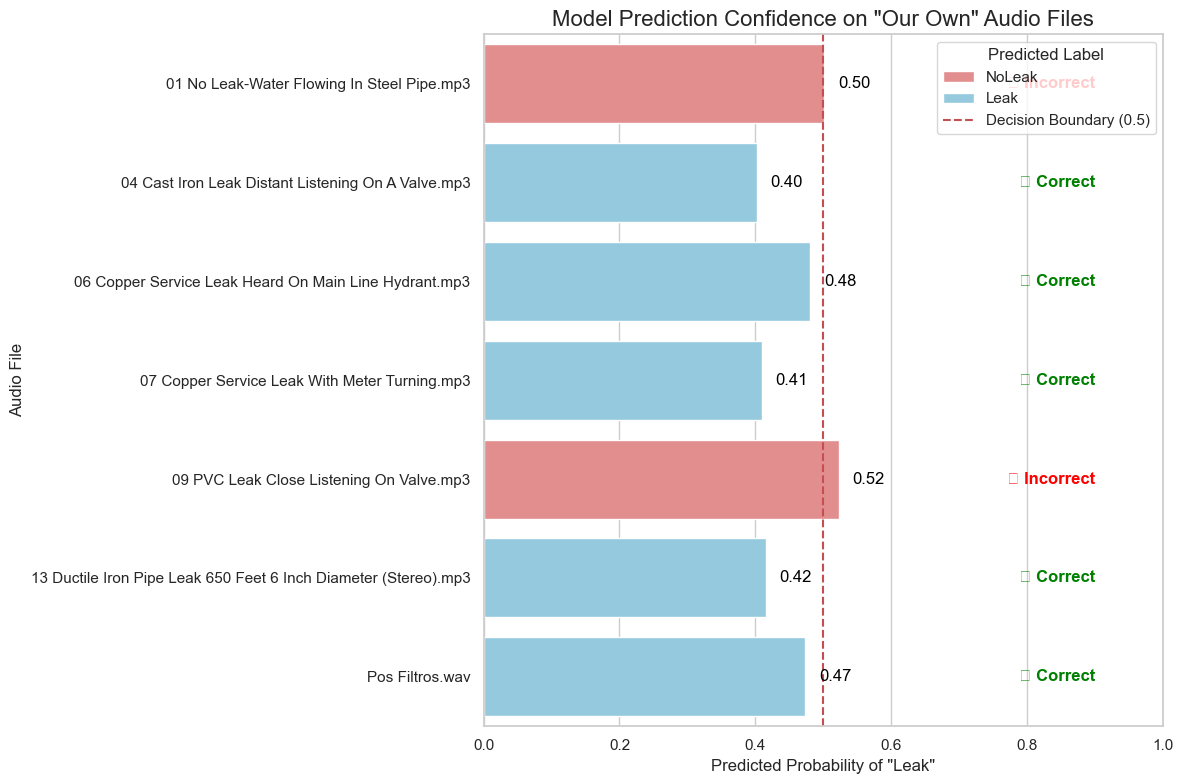

In [69]:
# --- Create a DataFrame for visualization ---
# Assumption: Filename contains 'leak' for true leaks. You may need to adjust this logic.
true_labels = ['Leak' if 'leak' in os.path.basename(f).lower() else 'NoLeak' for f in new_audio_files_valid]

# For the 'Pos Filtros.wav' file, let's assume it's a leak for visualization purposes
# as its name doesn't contain the label.
for i, f in enumerate(new_audio_files_valid):
    if 'Pos Filtros' in f:
        true_labels[i] = 'Leak'

results_df = pd.DataFrame({
    'filename': [os.path.basename(f) for f in new_audio_files_valid],
    'true_label': true_labels,
    'predicted_label': predicted_labels,
    'leak_probability': new_pred_probs.flatten()
})

# Determine if the prediction was correct
results_df['correct'] = results_df['true_label'] == results_df['predicted_label']

# --- Plot the results ---
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='leak_probability', y='filename', data=results_df, 
                        hue='predicted_label', dodge=False, palette={'Leak': 'skyblue', 'NoLeak': 'lightcoral'})

plt.title('Model Prediction Confidence on "Our Own" Audio Files', fontsize=16)
plt.xlabel('Predicted Probability of "Leak"', fontsize=12)
plt.ylabel('Audio File', fontsize=12)
plt.xlim(0, 1)
plt.axvline(x=0.5, color='r', linestyle='--', label='Decision Boundary (0.5)')
plt.legend(title='Predicted Label')

# Annotate bars with probability values
for index, row in results_df.iterrows():
    color = 'green' if row['correct'] else 'red'
    plt.text(row.leak_probability + 0.02, index, f"{row.leak_probability:.2f}", 
             color='black', va='center')
    plt.text(0.9, index, f"✓ Correct" if row['correct'] else "✗ Incorrect",
             color=color, va='center', ha='right', weight='bold')

plt.tight_layout()
plt.show()


## 7. Test Generalization on UrbanSound8K Dataset

This is an important final step to test how well our model generalizes to completely unrelated sounds. The **UrbanSound8K** dataset contains a wide variety of common urban sounds (e.g., car horns, dogs barking, sirens).

Our model, which was only trained to distinguish "Leak" from "NoLeak" sounds, should ideally classify all of these new sounds as **"NoLeak."** If it predicts "Leak" for any of them, it might indicate that some acoustic features of that urban sound are confusingly similar to what the model has learned to identify as a leak.

The process will be:
1.  Load the metadata for the UrbanSound8K dataset.
2.  Randomly select 10 audio files from across its different classes.
3.  Process each file into a Mel spectrogram.
4.  Use our trained model to predict the class.
5.  Display the results, comparing the model's prediction to the actual sound type.


In [70]:
# --- Parameters for UrbanSound8K ---
# Using os.path.join for platform compatibility
URBANSOUND_METADATA_PATH = os.path.join('..', 'UrbanSound8K', 'UrbanSound8K', 'metadata', 'UrbanSound8K.csv')
URBANSOUND_AUDIO_DIR = os.path.join('..', 'UrbanSound8K', 'UrbanSound8K', 'audio')
NUM_RANDOM_SAMPLES = 10

# Initialize dataframe outside the try block to ensure it's accessible later
urban_results_df = pd.DataFrame()

try:
    # --- Load metadata ---
    urban_df = pd.read_csv(URBANSOUND_METADATA_PATH)
    
    # --- Select 10 random samples ---
    if len(urban_df) >= NUM_RANDOM_SAMPLES:
        random_samples = urban_df.sample(n=NUM_RANDOM_SAMPLES)
        
        # --- Get full file paths ---
        urban_sound_files = []
        for index, row in random_samples.iterrows():
            # Correctly join path components
            file_path = os.path.join(URBANSOUND_AUDIO_DIR, f"fold{row['fold']}", row['slice_file_name'])
            urban_sound_files.append(file_path)

        print(f"Randomly selected {len(urban_sound_files)} files for testing generalization.")

        # --- Process and predict ---
        X_urban = np.array([audio_to_melspectrogram(file) for file in tqdm(urban_sound_files, desc="Processing UrbanSound files")])
        
        valid_indices_urban = [i for i, spec in enumerate(X_urban) if spec is not None]
        X_urban_valid = np.array([X_urban[i] for i in valid_indices_urban])
        urban_sound_files_valid = [urban_sound_files[i] for i in valid_indices_urban]
        random_samples_valid = random_samples.iloc[valid_indices_urban]

        if X_urban_valid.shape[0] > 0:
            X_urban_valid = X_urban_valid[..., np.newaxis]

            urban_pred_probs = model.predict(X_urban_valid)
            urban_predictions = (urban_pred_probs > 0.5).astype("int32")
            urban_predicted_labels = label_encoder.inverse_transform(urban_predictions.flatten())

            # --- Store results in a structured table for later use ---
            urban_results_df = pd.DataFrame({
                'Original Class': random_samples_valid['class'].values,
                'Filename': random_samples_valid['slice_file_name'].values,
                'Model Prediction': urban_predicted_labels,
                'full_path': urban_sound_files_valid
            })
            
            # Displaying a cleaner version without the full path
            display_df = urban_results_df[['Original Class', 'Filename', 'Model Prediction']]
            print("\n--- GENERALIZATION TEST RESULTS (UrbanSound8K) ---")
            print(display_df.to_string(index=False))

            # --- Final analysis ---
            leaks_predicted = urban_results_df[urban_results_df['Model Prediction'] == 'Leak'].shape[0]
            print(f"\nAnalysis: The model incorrectly identified {leaks_predicted} out of {len(urban_results_df)} urban sounds as 'Leak'.")

        else:
            print("Could not process any of the selected UrbanSound8K files.")
    else:
        print(f"Not enough samples in the metadata file to select {NUM_RANDOM_SAMPLES} files.")

except FileNotFoundError:
    print(f"Error: Could not find the UrbanSound8K metadata file at '{URBANSOUND_METADATA_PATH}'")
    print("Please ensure the dataset is correctly placed in your project directory.")



Randomly selected 10 files for testing generalization.


Processing UrbanSound files: 100%|██████████| 10/10 [00:00<00:00, 114.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

--- GENERALIZATION TEST RESULTS (UrbanSound8K) ---
 Original Class          Filename Model Prediction
       drilling 180937-4-1-12.wav           NoLeak
     jackhammer  188813-7-3-0.wav           NoLeak
       drilling   99192-4-0-0.wav           NoLeak
          siren  24347-8-0-14.wav           NoLeak
air_conditioner  63724-0-0-14.wav           NoLeak
       gun_shot  135526-6-9-0.wav           NoLeak
       drilling   84699-4-6-0.wav           NoLeak
air_conditioner   83502-0-0-0.wav           NoLeak
   street_music  157940-9-0-4.wav           NoLeak
   street_music  185373-9-0-6.wav           NoLeak

Analysis: The model incorrectly identified 0 out of 10 urban sounds as 'Leak'.


In [71]:
# --- Parameters for UrbanSound8K ---
# Correcting the path to account for the nested folder and notebook location
URBANSOUND_METADATA_PATH = '../UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv'
URBANSOUND_AUDIO_DIR = '../UrbanSound8K/UrbanSound8K/audio/'
NUM_RANDOM_SAMPLES = 10

try:
    # --- Load metadata ---
    urban_df = pd.read_csv(URBANSOUND_METADATA_PATH)
    
    # --- Select 10 random samples ---
    if len(urban_df) >= NUM_RANDOM_SAMPLES:
        random_samples = urban_df.sample(n=NUM_RANDOM_SAMPLES)
        
        # --- Get full file paths ---
        urban_sound_files = []
        for index, row in random_samples.iterrows():
            file_path = os.path.join(URBANSOUND_AUDIO_DIR, f"fold{row['fold']}", row['slice_file_name'])
            urban_sound_files.append(file_path)

        print(f"Randomly selected {len(urban_sound_files)} files for testing generalization.")

        # --- Process and predict ---
        X_urban = np.array([audio_to_melspectrogram(file) for file in tqdm(urban_sound_files, desc="Processing UrbanSound files")])
        
        valid_indices_urban = [i for i, spec in enumerate(X_urban) if spec is not None]
        X_urban_valid = np.array([X_urban[i] for i in valid_indices_urban])
        urban_sound_files_valid = [urban_sound_files[i] for i in valid_indices_urban]
        random_samples_valid = random_samples.iloc[valid_indices_urban]

        if X_urban_valid.shape[0] > 0:
            X_urban_valid = X_urban_valid[..., np.newaxis]

            urban_pred_probs = model.predict(X_urban_valid)
            urban_predictions = (urban_pred_probs > 0.5).astype("int32")
            urban_predicted_labels = label_encoder.inverse_transform(urban_predictions.flatten())

            # --- Display results in a structured table ---
            urban_results_df = pd.DataFrame({
                'Original Class': random_samples_valid['class'].values,
                'Filename': random_samples_valid['slice_file_name'].values,
                'Model Prediction': urban_predicted_labels
            })
            
            print("\n--- GENERALIZATION TEST RESULTS (UrbanSound8K) ---")
            print(urban_results_df.to_string(index=False))

            # --- Final analysis ---
            leaks_predicted = urban_results_df[urban_results_df['Model Prediction'] == 'Leak'].shape[0]
            print(f"\nAnalysis: The model incorrectly identified {leaks_predicted} out of {len(urban_results_df)} urban sounds as 'Leak'.")

        else:
            print("Could not process any of the selected UrbanSound8K files.")
    else:
        print(f"Not enough samples in the metadata file to select {NUM_RANDOM_SAMPLES} files.")

except FileNotFoundError:
    print(f"Error: Could not find the UrbanSound8K metadata file at '{URBANSOUND_METADATA_PATH}'")
    print("Please ensure the dataset is correctly placed in your project directory.")



Randomly selected 10 files for testing generalization.


Processing UrbanSound files: 100%|██████████| 10/10 [00:00<00:00, 124.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

--- GENERALIZATION TEST RESULTS (UrbanSound8K) ---
  Original Class           Filename Model Prediction
children_playing   13579-2-0-53.wav           NoLeak
children_playing    52882-2-0-7.wav           NoLeak
           siren   164782-8-0-2.wav           NoLeak
      jackhammer    54697-7-0-0.wav           NoLeak
        dog_bark    38231-3-0-0.wav           NoLeak
   engine_idling  144007-5-0-10.wav           NoLeak
        drilling   29721-4-0-10.wav           NoLeak
 air_conditioner  147926-0-0-52.wav           NoLeak
 air_conditioner 177621-0-0-126.wav           NoLeak
        car_horn    72567-1-0-1.wav           NoLeak

Analysis: The model incorrectly identified 0 out of 10 urban sounds as 'Leak'.


Randomly selected 200 files for testing generalization.


Processing UrbanSound files:   0%|          | 0/200 [00:00<?, ?it/s]

Processing UrbanSound files: 100%|██████████| 200/200 [00:01<00:00, 125.00it/s]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

--- GENERALIZATION TEST RESULTS (UrbanSound8K) ---


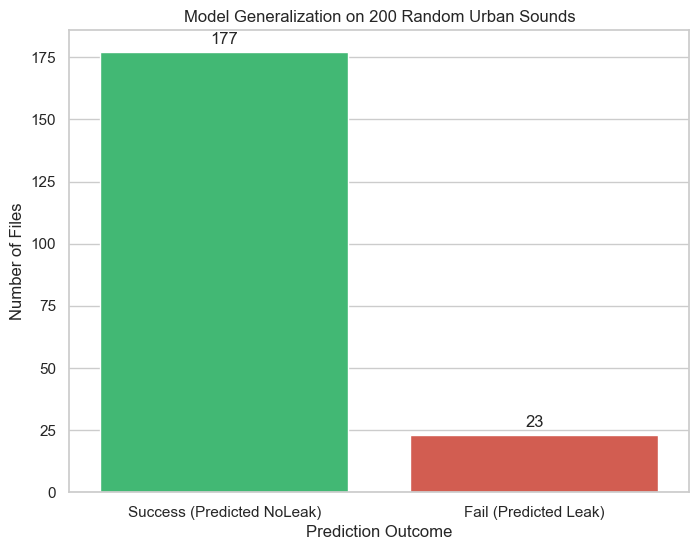


Analysis: The model incorrectly identified 23 files as 'Leak' (Fail).
It correctly identified 177 files as 'NoLeak' (Success).


In [75]:
# --- Parameters for UrbanSound8K ---
# Using os.path.join for platform compatibility
URBANSOUND_METADATA_PATH = os.path.join('..', 'UrbanSound8K', 'UrbanSound8K', 'metadata', 'UrbanSound8K.csv')
URBANSOUND_AUDIO_DIR = os.path.join('..', 'UrbanSound8K', 'UrbanSound8K', 'audio')
NUM_RANDOM_SAMPLES = 200 # Increased to 100

# Initialize dataframe outside the try block to ensure it's accessible later
urban_results_df = pd.DataFrame()

try:
    # --- Load metadata ---
    urban_df = pd.read_csv(URBANSOUND_METADATA_PATH)
    
    # --- Select 100 random samples ---
    if len(urban_df) >= NUM_RANDOM_SAMPLES:
        random_samples = urban_df.sample(n=NUM_RANDOM_SAMPLES, random_state=42) # Added random_state for reproducibility
        
        # --- Get full file paths ---
        urban_sound_files = []
        for index, row in random_samples.iterrows():
            # Correctly join path components
            file_path = os.path.join(URBANSOUND_AUDIO_DIR, f"fold{row['fold']}", row['slice_file_name'])
            urban_sound_files.append(file_path)

        print(f"Randomly selected {len(urban_sound_files)} files for testing generalization.")

        # --- Process and predict ---
        X_urban = np.array([audio_to_melspectrogram(file) for file in tqdm(urban_sound_files, desc="Processing UrbanSound files")])
        
        valid_indices_urban = [i for i, spec in enumerate(X_urban) if spec is not None]
        X_urban_valid = np.array([X_urban[i] for i in valid_indices_urban])

        if X_urban_valid.shape[0] > 0:
            X_urban_valid = X_urban_valid[..., np.newaxis]

            urban_pred_probs = model.predict(X_urban_valid)
            urban_predictions = (urban_pred_probs > 0.5).astype("int32")
            urban_predicted_labels = label_encoder.inverse_transform(urban_predictions.flatten())

            # --- Store results ---
            urban_results_df = pd.DataFrame({'Model Prediction': urban_predicted_labels})
            
            # --- Analysis ---
            leaks_predicted = (urban_results_df['Model Prediction'] == 'Leak').sum()
            noleaks_predicted = len(urban_results_df) - leaks_predicted
            
            print("\n--- GENERALIZATION TEST RESULTS (UrbanSound8K) ---")
            
            # --- Visualization of predictions ---
            plt.figure(figsize=(8, 6))
            # Updated to address FutureWarning: assign 'x' to 'hue' and set legend=False.
            ax = sns.countplot(x='Model Prediction', data=urban_results_df, palette={"Leak": "#e74c3c", "NoLeak": "#2ecc71"}, order=['NoLeak', 'Leak'], hue='Model Prediction', legend=False)
            # To fix the UserWarning, we explicitly set the ticks before setting the labels.
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(['Success (Predicted NoLeak)', 'Fail (Predicted Leak)'])
            plt.title(f'Model Generalization on {NUM_RANDOM_SAMPLES} Random Urban Sounds')
            plt.xlabel('Prediction Outcome')
            plt.ylabel('Number of Files')
            
            # Adding text annotations to the bars
            for p in ax.patches:
                ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=12)
            plt.show()

            print(f"\nAnalysis: The model incorrectly identified {leaks_predicted} files as 'Leak' (Fail).")
            print(f"It correctly identified {noleaks_predicted} files as 'NoLeak' (Success).")

        else:
            print("Could not process any of the selected UrbanSound8K files.")
    else:
        print(f"Not enough samples in the metadata file to select {NUM_RANDOM_SAMPLES} files.")

except FileNotFoundError:
    print(f"Error: Could not find the UrbanSound8K metadata file at '{URBANSOUND_METADATA_PATH}'")
    print("Please ensure the dataset is correctly placed in your project directory.")

Randomly selected 200 files for testing generalization.


Processing UrbanSound files: 100%|██████████| 200/200 [00:01<00:00, 123.46it/s]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

--- GENERALIZATION TEST RESULTS (UrbanSound8K) ---


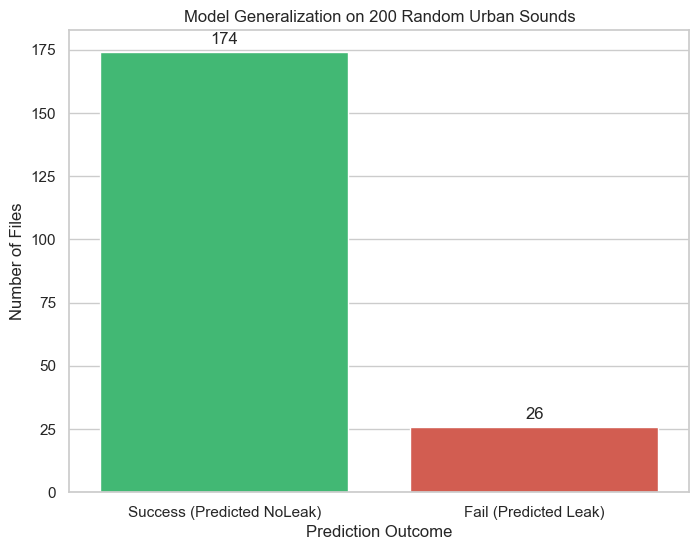


Analysis: The model incorrectly identified 26 files as 'Leak' (Fail).
It correctly identified 174 files as 'NoLeak' (Success).


In [76]:
# --- Parameters for UrbanSound8K ---
# Using os.path.join for platform compatibility
URBANSOUND_METADATA_PATH = os.path.join('..', 'UrbanSound8K', 'UrbanSound8K', 'metadata', 'UrbanSound8K.csv')
URBANSOUND_AUDIO_DIR = os.path.join('..', 'UrbanSound8K', 'UrbanSound8K', 'audio')
NUM_RANDOM_SAMPLES = 200 # Increased to 100

# Initialize dataframe outside the try block to ensure it's accessible later
urban_results_df = pd.DataFrame()

try:
    # --- Load metadata ---
    urban_df = pd.read_csv(URBANSOUND_METADATA_PATH)
    
    # --- Select 100 random samples ---
    if len(urban_df) >= NUM_RANDOM_SAMPLES:
        random_samples = urban_df.sample(n=NUM_RANDOM_SAMPLES, random_state=77) # Added random_state for reproducibility
        
        # --- Get full file paths ---
        urban_sound_files = []
        for index, row in random_samples.iterrows():
            # Correctly join path components
            file_path = os.path.join(URBANSOUND_AUDIO_DIR, f"fold{row['fold']}", row['slice_file_name'])
            urban_sound_files.append(file_path)

        print(f"Randomly selected {len(urban_sound_files)} files for testing generalization.")

        # --- Process and predict ---
        X_urban = np.array([audio_to_melspectrogram(file) for file in tqdm(urban_sound_files, desc="Processing UrbanSound files")])
        
        valid_indices_urban = [i for i, spec in enumerate(X_urban) if spec is not None]
        X_urban_valid = np.array([X_urban[i] for i in valid_indices_urban])

        if X_urban_valid.shape[0] > 0:
            X_urban_valid = X_urban_valid[..., np.newaxis]

            urban_pred_probs = model.predict(X_urban_valid)
            urban_predictions = (urban_pred_probs > 0.5).astype("int32")
            urban_predicted_labels = label_encoder.inverse_transform(urban_predictions.flatten())

            # --- Store results ---
            urban_results_df = pd.DataFrame({'Model Prediction': urban_predicted_labels})
            
            # --- Analysis ---
            leaks_predicted = (urban_results_df['Model Prediction'] == 'Leak').sum()
            noleaks_predicted = len(urban_results_df) - leaks_predicted
            
            print("\n--- GENERALIZATION TEST RESULTS (UrbanSound8K) ---")
            
            # --- Visualization of predictions ---
            plt.figure(figsize=(8, 6))
            # Updated to address FutureWarning: assign 'x' to 'hue' and set legend=False.
            ax = sns.countplot(x='Model Prediction', data=urban_results_df, palette={"Leak": "#e74c3c", "NoLeak": "#2ecc71"}, order=['NoLeak', 'Leak'], hue='Model Prediction', legend=False)
            # To fix the UserWarning, we explicitly set the ticks before setting the labels.
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(['Success (Predicted NoLeak)', 'Fail (Predicted Leak)'])
            plt.title(f'Model Generalization on {NUM_RANDOM_SAMPLES} Random Urban Sounds')
            plt.xlabel('Prediction Outcome')
            plt.ylabel('Number of Files')
            
            # Adding text annotations to the bars
            for p in ax.patches:
                ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=12)
            plt.show()

            print(f"\nAnalysis: The model incorrectly identified {leaks_predicted} files as 'Leak' (Fail).")
            print(f"It correctly identified {noleaks_predicted} files as 'NoLeak' (Success).")

        else:
            print("Could not process any of the selected UrbanSound8K files.")
    else:
        print(f"Not enough samples in the metadata file to select {NUM_RANDOM_SAMPLES} files.")

except FileNotFoundError:
    print(f"Error: Could not find the UrbanSound8K metadata file at '{URBANSOUND_METADATA_PATH}'")
    print("Please ensure the dataset is correctly placed in your project directory.")

## 8. Edge AI Deployment Considerations

Yes, this model is a strong candidate for deployment on Edge AI devices, but there are important considerations, especially regarding the pre-processing pipeline.

### Model Suitability

-   **Size and Complexity:** The model is relatively small. With **109,313 parameters**, the resulting file size is under 500 KB. This is well within the capacity of many edge devices, including more powerful microcontrollers.
-   **Standard Layers:** The model uses standard Keras layers (`Conv2D`, `MaxPooling2D`, `Dense`, etc.), which are broadly supported by edge inference engines.

### Deployment Path: TensorFlow Lite

The most common path for deploying a Keras model to an edge device is to convert it to the **TensorFlow Lite (TFLite)** format.

1.  **Conversion:** You can save your trained Keras model and then use the `tf.lite.TFLiteConverter` to create a `.tflite` file.
2.  **Quantization (Optional but Recommended):** To further reduce the model's size and speed up inference (especially on supported hardware), you can apply quantization during the conversion process. This converts the model's weights from 32-bit floats to 16-bit floats or even 8-bit integers.

Here's a brief code example of what that conversion looks like:
```python
# Assuming 'model' is your trained Keras model
import tensorflow as tf

# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to a file
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

# Example with quantization (e.g., float16)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.lite.float16]
tflite_fp16_model = converter.convert()

with open('model_fp16.tflite', 'wb') as f:
  f.write(tflite_fp16_model)
```

### The Main Challenge: Feature Extraction on the Edge

The most significant challenge is not the model itself, but replicating the **audio pre-processing pipeline** on the target device. The inference must run on a Mel spectrogram with the exact same parameters used in training:

-   Audio clipped/padded to 10 seconds at 22050 Hz.
-   Mel spectrogram with 128 Mel bands.
-   Power-to-DB conversion.

The `librosa` library is excellent for training but is generally too large and slow for resource-constrained edge devices.

-   **For higher-power edge devices (e.g., Raspberry Pi, NVIDIA Jetson):** You might be able to install `librosa`, but performance could be a bottleneck. It would be better to find or implement the spectrogram logic using a lighter-weight library in Python (like `scipy`'s FFT functions) or a C++ library for better performance.
-   **For microcontrollers (e.g., ESP32, ARM Cortex-M):** `librosa` is not an option. You would need to re-implement the entire feature extraction process in C/C++. Libraries like **CMSIS-DSP** (for ARM cores) provide highly optimized functions for FFTs and other DSP operations that are the building blocks for creating a Mel spectrogram. This is a non-trivial engineering task.

### Conclusion

The CNN model's architecture is perfectly suited for Edge AI. The primary development effort will be to create an efficient and equivalent feature extraction pipeline that can run on your specific target hardware to generate the Mel spectrogram that the model expects as input.
